# Some online simulation model

mentioned in the following links: 
- [https://arguablywrong.home.blog/2020/03/12/epidemiological-modeling-costs-of-controls/](https://arguablywrong.home.blog/2020/03/12/epidemiological-modeling-costs-of-controls/) 
- [https://pastebin.com/xZvUMqWN](https://pastebin.com/xZvUMqWN)

In [8]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import matplotlib.widgets as wid
from recordtype import recordtype   
#changed because namedtuple is immutable (can't be modified)

Prepare model:

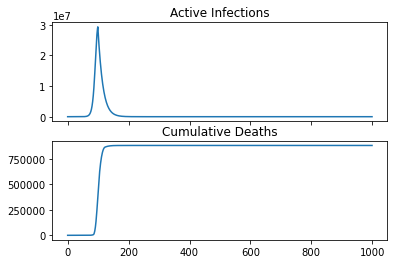

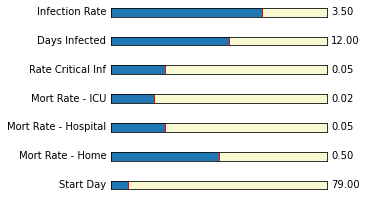

In [12]:
PopState = namedtuple("PopState", [
    "day", 
    "susceptible", 
    "infected", 
    "dead", 
    "recovered",
])
EpiParams = recordtype("EpiParams", [
    "days_infected", 
    "infection_rate", 
    "frac_critical", 
    "frac_dead_icu",
    "frac_dead_hospital",
    "frac_dead_home",
    "start_day",
    "controlled_infection_rate",
])
 
ICU_BEDS = 30000
HOSPITAL_BEDS = 300000
 
def update_state(state, params):
    day = state.day
    S = state.susceptible
    I = state.infected
    D = state.dead
    R = state.recovered
    N = S + I + D + R
     
    days_betw_contacts = params.days_infected / params.infection_rate
    if day >= params.start_day:
        days_betw_contacts = params.days_infected / params.controlled_infection_rate
     
    new_infections = (I * S) / (N * days_betw_contacts)
    recovered_infections = (I / params.days_infected) * (1 - params.frac_critical)
 
    # For critical cases, we split into ICU, hospital, and home care, in descending order
    C = I * params.frac_critical;
    C_icu = min(C, ICU_BEDS);
    C_hospital = 0 if C < ICU_BEDS else min(C - ICU_BEDS, HOSPITAL_BEDS)
    C_home = 0 if C < (ICU_BEDS + HOSPITAL_BEDS) else C - (ICU_BEDS + HOSPITAL_BEDS)
 
    recovered_critical = (
        ((C_icu / params.days_infected) * (1 - params.frac_dead_icu)) + 
        ((C_hospital / params.days_infected) * (1 - params.frac_dead_hospital)) + 
        ((C_home / params.days_infected) * (1 - params.frac_dead_home))
    )
     
    dead_critical = (
        ((C_icu / params.days_infected) * (params.frac_dead_icu)) + 
        ((C_hospital / params.days_infected) * (params.frac_dead_hospital)) + 
        ((C_home / params.days_infected) * (params.frac_dead_home))
    )
     
    newS = S - new_infections
    newI = I + new_infections - recovered_infections - recovered_critical - dead_critical
    newR = R + recovered_infections + recovered_critical
    newD = D + dead_critical
     
    return PopState(day + 1, newS, newI, newD, newR)
 
def run_model(state, params):
    infections = [state.infected]
    deaths = [state.dead]
    while state.day<1000: #(state.infected) >= 1:   # changed because, as implemented, the chart needs a constant number of values on x-axis
        state = update_state(state, params)
        infections.append(state.infected)
        deaths.append(state.dead)
    return infections, deaths, state
     
total_population = 80 * 1e6

init_state = PopState(
    day=1,
    susceptible=total_population - 1, 
    infected=1, 
    dead=0, 
    recovered=0)
    
params = EpiParams(
    days_infected=12, 
    infection_rate=3.5, 
    frac_critical=0.05, 
    frac_dead_icu=0.02,
    frac_dead_hospital=0.05,
    frac_dead_home=0.5,
    start_day=100,
    # Modify this parameter to vary the strength of infection controls
    controlled_infection_rate=1,
)
 
infections_over_time, deaths_over_time, final_state = run_model(init_state, params)


fig1, (ax1,ax2) = plt.subplots(2, 1, sharex='col')
fig2 = plt.figure()

line1,=ax1.plot(infections_over_time)
line2,=ax2.plot(deaths_over_time)


ax1.set_title('Active Infections')
ax2.set_title('Cumulative Deaths')


axcolor = 'lightgoldenrodyellow'

#axis objects (for sliders)
axIR = fig2.add_axes([0.3, .9, 0.5, 0.03], facecolor=axcolor)
axdays_infected = fig2.add_axes([0.3, .8, 0.5, 0.03], facecolor=axcolor)
axfrac_critical = fig2.add_axes([0.3, .7, 0.5, 0.03], facecolor=axcolor)
axfrac_dead_icu = fig2.add_axes([0.3, .6, 0.5, 0.03], facecolor=axcolor)
axfrac_dead_hospital = fig2.add_axes([0.3, .5, 0.5, 0.03], facecolor=axcolor)
axfrac_dead_home = fig2.add_axes([0.3, .4, 0.5, 0.03], facecolor=axcolor)
axstart_day = fig2.add_axes([0.3, .3, 0.5, 0.03], facecolor=axcolor)



#slider objects
sIR = wid.Slider(axIR, 'Infection Rate', 0, 5.0, valinit=3.5, valstep=.02)
sdays_infected = wid.Slider(axdays_infected, 'Days Infected', 1, 21, valinit=12, valstep=1)
sfrac_critical = wid.Slider(axfrac_critical, 'Rate Critical Inf', 0, .2, valinit=.05, valstep=.01) 
sfrac_dead_icu = wid.Slider(axfrac_dead_icu, 'Mort Rate - ICU', 0, .1, valinit=.02, valstep=.01)
sfrac_dead_hospital = wid.Slider(axfrac_dead_hospital, 'Mort Rate - Hospital', 0, .2, valinit=.05, valstep=.01)
sfrac_dead_home = wid.Slider(axfrac_dead_home, 'Mort Rate - Home', 0, 1, valinit=.5, valstep=.01)
sstart_day = wid.Slider(axstart_day, 'Start Day', 1, 999, valinit=79, valstep=1)

#    days_infected=12, 
#    frac_critical=0.05, 
#    frac_dead_icu=0.02,
#    frac_dead_hospital=0.05,
#    frac_dead_home=0.5,
#    start_day=100,




def update(val):
    params.controlled_infection_rate = sIR.val
    params.days_infected = sdays_infected.val
    params.frac_critical = sfrac_critical.val
    params.frac_dead_icu = sfrac_dead_icu.val
    params.frac_dead_hospital = sfrac_dead_hospital.val
    params.frac_dead_home = sfrac_dead_home.val
    params.start_day = sstart_day.val
    
    
    
    
    infections_over_time, deaths_over_time, final_state = run_model(init_state, params)
    
    line1.set_ydata(infections_over_time)
    line2.set_ydata(deaths_over_time)

    fig1.canvas.draw_idle()


sIR.on_changed(update)
sdays_infected.on_changed(update)
sfrac_critical.on_changed(update)
sfrac_dead_icu.on_changed(update)
sfrac_dead_hospital.on_changed(update)
sfrac_dead_home.on_changed(update)
sstart_day.on_changed(update)


plt.show()